In [183]:
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import redis
import json
import h5py

In [184]:
batch_size = 128
nb_classes = 10
nb_epoch = 20

In [185]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [186]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

60000 train samples
10000 test samples


In [187]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [188]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation("softmax"))

In [189]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           401920      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dropout_1[0][0]                  
___________________________________________________________________________________________

In [190]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(),
              metrics=["accuracy"])

In [191]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s - loss: 0.2421 - acc: 0.9251 - val_loss: 0.0980 - val_acc: 0.9697
Epoch 2/20
60000/60000 [==============================] - 8s - loss: 0.1021 - acc: 0.9693 - val_loss: 0.0929 - val_acc: 0.9726
Epoch 3/20
60000/60000 [==============================] - 8s - loss: 0.0745 - acc: 0.9778 - val_loss: 0.0936 - val_acc: 0.9734
Epoch 4/20
60000/60000 [==============================] - 9s - loss: 0.0608 - acc: 0.9819 - val_loss: 0.0685 - val_acc: 0.9807
Epoch 5/20
60000/60000 [==============================] - 9s - loss: 0.0499 - acc: 0.9845 - val_loss: 0.0702 - val_acc: 0.9805
Epoch 6/20
60000/60000 [==============================] - 9s - loss: 0.0438 - acc: 0.9870 - val_loss: 0.0737 - val_acc: 0.9814
Epoch 7/20
60000/60000 [==============================] - 9s - loss: 0.0392 - acc: 0.9889 - val_loss: 0.0724 - val_acc: 0.9831
Epoch 8/20
60000/60000 [==============================] - 11s

In [192]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [193]:
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.130531955769
Test accuracy: 0.982


In [194]:
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.130531955769
Test accuracy: 0.982


### Saving the model

In [16]:
json_string = model.to_json()
open("mnist_mlp.json", "w").write(json_string)
model.save_weights("mnist_mlp.h5")

[WARNING] mnist_mlp.h5 already exists - overwrite? [y/n]n


### Saving to redis

In [27]:
r = redis.StrictRedis(host="localhost", port=6379, db=0)

In [29]:
r = redis.StrictRedis(host="redis.local.pcfdev.io", port=55098, password="c2aa5c33-9099-4d37-a27f-fbb8af882e2d")

In [30]:
r.info()

{'aof_base_size': 0,
 'aof_buffer_length': 0,
 'aof_current_rewrite_time_sec': -1,
 'aof_current_size': 2692440,
 'aof_delayed_fsync': 0,
 'aof_enabled': 1,
 'aof_last_bgrewrite_status': 'ok',
 'aof_last_rewrite_time_sec': -1,
 'aof_last_write_status': 'ok',
 'aof_pending_bio_fsync': 0,
 'aof_pending_rewrite': 0,
 'aof_rewrite_buffer_length': 0,
 'aof_rewrite_in_progress': 0,
 'aof_rewrite_scheduled': 0,
 'arch_bits': 64,
 'blocked_clients': 0,
 'client_biggest_input_buf': 0,
 'client_longest_output_list': 0,
 'cluster_enabled': 0,
 'config_file': '/var/vcap/store/cf-redis-broker/redis-data/c88bb273-e6cf-4452-8105-3decd246aadf/redis.conf',
 'connected_clients': 3,
 'connected_slaves': 0,
 'db0': {'avg_ttl': 0, 'expires': 0, 'keys': 2},
 'evicted_keys': 0,
 'expired_keys': 0,
 'gcc_version': '4.8.4',
 'hz': 10,
 'instantaneous_input_kbps': 0.0,
 'instantaneous_ops_per_sec': 0,
 'instantaneous_output_kbps': 0.0,
 'keyspace_hits': 18,
 'keyspace_misses': 0,
 'latest_fork_usec': 586,
 'loa

In [18]:
r.set("model", json_string)

True

In [19]:
weights = h5py.File("mnist_mlp.h5", "r")

In [20]:
for i in weights:
    print(i, weights[i])

activation_1 <HDF5 group "/activation_1" (0 members)>
activation_2 <HDF5 group "/activation_2" (0 members)>
activation_3 <HDF5 group "/activation_3" (0 members)>
dense_1 <HDF5 group "/dense_1" (2 members)>
dense_2 <HDF5 group "/dense_2" (2 members)>
dense_3 <HDF5 group "/dense_3" (2 members)>
dropout_1 <HDF5 group "/dropout_1" (0 members)>
dropout_2 <HDF5 group "/dropout_2" (0 members)>


In [21]:
# trick to save the weights to redis and the to load it on CF
with open("mnist_mlp.h5", "rb") as f:
    r.set("weights", f.read())

In [22]:
weights = r.get("weights")

In [23]:
with open("mnist_mlp_weights.h5", "wb") as f:
    f.write(weights)

In [24]:
model = model_from_json(r.get("model").decode("UTF-8"))

In [25]:
model.load_weights("mnist_mlp_weights.h5")

In [28]:
r.keys()

[b'weights', b'model']

### Loading the model

In [43]:
model = model_from_json(open("mnist_mlp.json").read())
model.load_weights("mnist_mlp.h5")
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop())

### Prediction

In [44]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [45]:
plt.imshow(X_train[1].reshape(28,28), cmap="Greys_r")
plt.show()

In [149]:
img = Image.open("four_test.png").convert("L")

In [150]:
img

In [151]:
data = np.asarray(img, dtype="int32")

In [152]:
inverted_img = ImageOps.invert(img)

In [153]:
inverted_img

In [154]:
data = np.asarray(inverted_img, dtype="int32")

In [7]:
rescaled_data = (data/255).reshape(28,28)

In [48]:
plt.imshow(rescaled_data, cmap="Greys_r")
plt.show()

In [49]:
model.predict_classes(np.vstack([rescaled_data.reshape(-1)]))

1/1 [==============================] - 0s


array([4])

In [9]:
rescaled_data.sum()

46.129411764705878

In [10]:
stacked_data = np.vstack([rescaled_data.reshape(-1)])

In [12]:
stacked_data.sum()

46.129411764705878

### With sketch.js

In [416]:
img = Image.open("four.png").convert("RGBA")

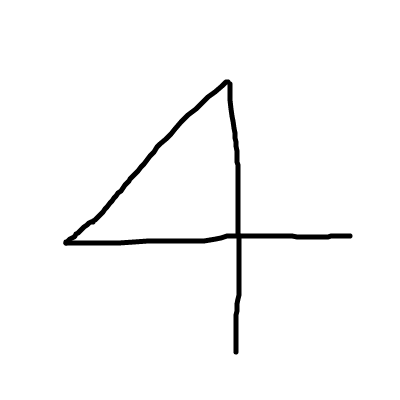

In [417]:
img

In [418]:
img = np.asarray(img, dtype="int32")[:,:,3]

In [419]:
img = Image.fromarray(img).convert("L")

In [420]:
resized_image = img.resize((28,28), Image.ANTIALIAS)

In [421]:
resized_image = np.asarray(resized_image, dtype="int32")

In [422]:
# 255 * 5
Image.fromarray(resized_image * 5).convert("L")

In [423]:
# maybe add another rescaling factor
rescaled_data = (resized_image/255)

In [424]:
rescaled_data.reshape(-1).sum()

22.090196078431369

In [425]:
model.predict(np.vstack([rescaled_data.reshape(-1)]))

array([[  1.51035798e-04,   1.60803771e-04,   3.89318913e-02,
          1.05397520e-03,   9.37297583e-01,   1.33649679e-03,
          1.30895583e-04,   1.08029610e-02,   1.28804313e-04,
          1.00055281e-02]])

In [426]:
model.predict_classes(np.vstack([resized_image.reshape(-1) / 255]))

1/1 [==============================] - 0s


array([4])

### Increase the brightness

In [427]:
resized_image = Image.fromarray(resized_image).convert("L")

In [428]:
brightness = ImageEnhance.Brightness(resized_image)

In [429]:
brightness.enhance(2)

In [434]:
rescaled_data = (np.asarray(brightness.enhance(2), dtype="int32") / 255)

In [435]:
model.predict_classes(np.vstack([rescaled_data.reshape(-1)]))

1/1 [==============================] - 0s


array([4])

In [436]:
rescaled_data.reshape(-1).sum()

43.921568627450981